In [1]:
!pip install fasttext

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Total training dataset: 3499
Total Negative (training): 184
Total Neutral (training): 534
Total Positive (training): 2781

Total testing dataset: 1500
Total Negative (testing): 86
Total Neutral (testing): 231
Total Positive (testing): 1183

Training data distribution:
Sentiment
Positive    2781
Neutral      534
Negative     184
Name: count, dtype: int64

Testing data distribution:
Sentiment
Positive    1183
Neutral      231
Negative      86
Name: count, dtype: int64

Classification Report:
               precision    recall  f1-score   support

    Negative       0.08      0.23      0.11        86
     Neutral       0.50      0.00      0.01       231
    Positive       0.80      0.83      0.81      1183

    accuracy                           0.67      1500
   macro avg       0.46      0.36      0.31      1500
weighted avg       0.71      0.67      0.65     

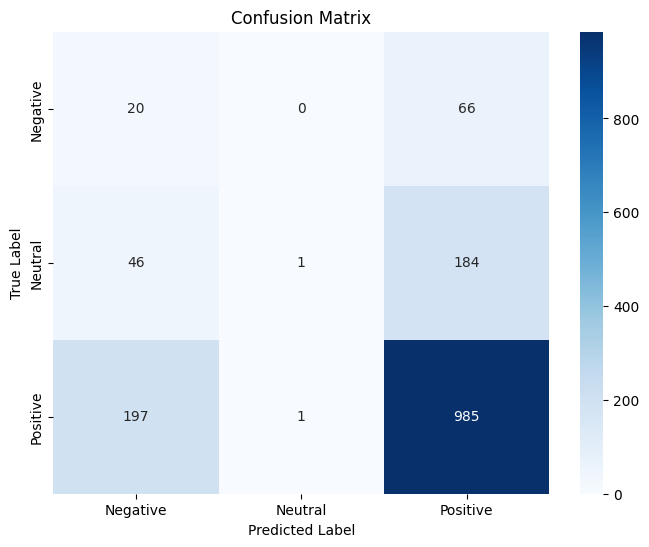

Accuracy: 0.6706666666666666
Sentiment analysis time: 791.20 seconds


In [7]:
import torch
from torch import nn
from transformers import BertModel, BertTokenizer
import fasttext
import numpy as np
import pandas as pd
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.utils import resample
import time

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    """ Lowercase, remove punctuation, numbers, and stopwords, and apply lemmatization. """
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return tokens

# Mount Google Drive to access files
drive.mount('/content/drive')

# Load and preprocess data
data_path = '/content/drive/My Drive/experiment/example_hotel_review.csv'
reviews_df = pd.read_csv(data_path)
reviews_df['Processed_Reviews'] = reviews_df.apply(lambda row: preprocess_text(row['Positive_Review'] + " " + row['Negative_Review']), axis=1)

# Split the data into training and testing sets
train_df, test_df = train_test_split(reviews_df, test_size=0.3, random_state=42)

# Convert numerical labels to string labels based on new thresholds
def get_sentiment_label(score):
    if score < 5:
        return 'Negative'
    elif 5 <= score < 7:
        return 'Neutral'
    else:
        return 'Positive'

train_df['Sentiment'] = train_df['Reviewer_Score'].apply(get_sentiment_label)
test_df['Sentiment'] = test_df['Reviewer_Score'].apply(get_sentiment_label)

# Print total dataset and sentiment counts for training and testing sets
print("\nTotal training dataset:", len(train_df))
print("Total Negative (training):", len(train_df[train_df['Sentiment'] == 'Negative']))
print("Total Neutral (training):", len(train_df[train_df['Sentiment'] == 'Neutral']))
print("Total Positive (training):", len(train_df[train_df['Sentiment'] == 'Positive']))

print("\nTotal testing dataset:", len(test_df))
print("Total Negative (testing):", len(test_df[test_df['Sentiment'] == 'Negative']))
print("Total Neutral (testing):", len(test_df[test_df['Sentiment'] == 'Neutral']))
print("Total Positive (testing):", len(test_df[test_df['Sentiment'] == 'Positive']))

# Check class distribution
print("\nTraining data distribution:")
print(train_df['Sentiment'].value_counts())
print("\nTesting data distribution:")
print(test_df['Sentiment'].value_counts())

# Handle class imbalance with oversampling
neg_train = train_df[train_df['Sentiment'] == 'Negative']
neu_train = train_df[train_df['Sentiment'] == 'Neutral']
pos_train = train_df[train_df['Sentiment'] == 'Positive']

# Upsample minority classes
neg_train_upsampled = resample(neg_train, replace=True, n_samples=len(pos_train), random_state=42)
neu_train_upsampled = resample(neu_train, replace=True, n_samples=len(pos_train), random_state=42)

# Combine upsampled classes with majority class
train_df_upsampled = pd.concat([pos_train, neg_train_upsampled, neu_train_upsampled])

# Save processed training reviews to a text file for FastText training
train_reviews_path = '/content/drive/My Drive/experiment/train_reviews.txt'
with open(train_reviews_path, 'w') as f:
    for review in train_df_upsampled['Processed_Reviews']:
        f.write(" ".join(review) + "\n")

# Train FastText model on training data
ft_model = fasttext.train_unsupervised(train_reviews_path, model='skipgram')

# Load BERT model and tokenizer
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class BertFastTextSentimentAnalysis(nn.Module):
    def __init__(self, bert_model, fasttext_model, bert_dim=768, ft_dim=100, device='cpu'):
        super().__init__()
        self.bert = bert_model
        self.fasttext = fasttext_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(bert_dim + ft_dim, 3)  # Output for three classes
        self.device = device

    def forward(self, input_ids, attention_mask, texts):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(bert_outputs.pooler_output)

        fasttext_embeddings = []
        for text in texts:
            vectors = [self.fasttext.get_word_vector(token) for token in text]
            if vectors:
                avg_vector = np.mean(vectors, axis=0)
            else:
                avg_vector = np.zeros((100,))
            fasttext_embeddings.append(avg_vector)

        fasttext_embeddings = np.array(fasttext_embeddings)  # Convert list of numpy arrays to numpy array
        fasttext_embeddings = torch.tensor(fasttext_embeddings, dtype=torch.float32, device=self.device)

        combined_features = torch.cat((pooled_output, fasttext_embeddings), dim=1)
        logits = self.classifier(combined_features)
        return logits

device = 'cuda' if torch.cuda.is_available() else 'cpu'
hybrid_model = BertFastTextSentimentAnalysis(bert_model, ft_model, device=device)
hybrid_model.to(device)

def predict_sentiment(model, texts):
    processed_texts = [' '.join(tokens) for tokens in texts]  # Convert token lists back to strings for BERT
    encoded_inputs = tokenizer(processed_texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
    input_ids = encoded_inputs['input_ids'].to(device)
    attention_mask = encoded_inputs['attention_mask'].to(device)
    predictions = []
    with torch.no_grad():
        logits = model(input_ids, attention_mask, texts)  # texts are the original token lists
        predictions = torch.argmax(logits, dim=-1).cpu().tolist()
    return predictions

# Prepare training and testing data
train_texts = train_df_upsampled['Processed_Reviews'].tolist()
train_labels = train_df_upsampled['Sentiment'].tolist()

test_texts = test_df['Processed_Reviews'].tolist()
test_labels = test_df['Sentiment'].tolist()

# Record start time
start_time = time.time()

# Evaluate the model using testing data
test_predictions = predict_sentiment(hybrid_model, test_texts)

# Record end time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

# Convert predicted labels to string
label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
test_predictions_str = [label_map[pred] for pred in test_predictions]

# Calculate accuracy and generate a confusion matrix
accuracy = accuracy_score(test_labels, test_predictions_str)
conf_matrix = confusion_matrix(test_labels, test_predictions_str, labels=['Negative', 'Neutral', 'Positive'])

# Convert confusion matrix to text
conf_matrix_text = pd.DataFrame(conf_matrix, index=['Negative', 'Neutral', 'Positive'], columns=['Negative', 'Neutral', 'Positive']).to_string()

# Calculate and print the classification report with zero_division parameter
report = classification_report(test_labels, test_predictions_str, zero_division=0)
print("\nClassification Report:\n", report)

# Print confusion matrix as text
print("\nConfusion Matrix:\n", conf_matrix_text)

# Print total dataset and sentiment counts
total_dataset = len(test_labels)
total_negative = test_labels.count('Negative')
total_neutral = test_labels.count('Neutral')
total_positive = test_labels.count('Positive')

print(f"\nTotal dataset: {total_dataset}")
print(f"Total Negative: {total_negative}")
print(f"Total Neutral: {total_neutral}")
print(f"Total Positive: {total_positive}")

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy:", accuracy)
print(f"Sentiment analysis time: {elapsed_time:.2f} seconds")
